 Helpful links and tutorials:
 - DeepEval guide for using custom LLMs (Google Vertex AI example): https://deepeval.com/guides/guides-using-custom-llms#google-vertexai-example
 - Example Jupyter notebook in Google Colab: https://colab.research.google.com/drive/1PPxYEBa6eu__LquGoFFJZkhYgWVYE6kh?usp=sharing

In [21]:
import warnings
warnings.filterwarnings('ignore')


Custom Google Generative AI Implementation for DeepEval <br><br>
This code demonstrates how to create a custom LLM wrapper for DeepEval using Google's Generative AI models. The implementation extends DeepEval's DeepEvalBaseLLM class to integrate with LangChain's ChatGoogleGenerativeAI, specifically using the Gemini 2.5 Flash model. The wrapper provides both synchronous and asynchronous text generation methods (generate and a_generate) that interface with DeepEval's evaluation framework, allowing you to use Google's advanced language models for automated evaluation of text quality across multiple dimensions like coherence, groundedness, relevance, accuracy, and completeness. This setup enables comprehensive evaluation of academic abstracts against their source articles using Google's state-of-the-art language understanding capabilities.

In [15]:
from deepeval.models.base_model import DeepEvalBaseLLM
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os

load_dotenv()

google_api_key = os.getenv('GOOGLE_API_KEY')

class GoogleGenerativeAI(DeepEvalBaseLLM):
    """Class to implement Vertex AI for DeepEval"""
    def __init__(self, model):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Vertex AI Model"


custom_model_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    google_api_key=google_api_key,
    max_tokens=5000,
    timeout=None,
    max_retries=5,
    thinking_budget=0
)


eval_model = GoogleGenerativeAI(model=custom_model_gemini)
print(eval_model.generate("Write me a joke"))

Why don't scientists trust atoms?

Because they make up everything!


In [1]:
from datasets import load_dataset

# Download the "ccdv/arxiv-summarization" dataset from Hugging Face
arxiv_dataset = load_dataset("ccdv/arxiv-summarization")

c:\Users\Felps\Documents\Github\deep_eval_101\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load train and test splits into pandas DataFrames
arxiv_train_df = arxiv_dataset['train'].to_pandas()
arxiv_test_df = arxiv_dataset['test'].to_pandas()


In [36]:
articles = arxiv_train_df.sample(10)
articles

,article,abstract
37759,kondo insulators are a peculiar group of rare ...,we investigate the effect of the coulomb inter...
81969,the most basic features of neutron stars ( ns ...,we perform a bayesian analysis of probability ...
101830,gravitational lensing is known to be a powerfu...,an attempt to measure the hubble constant with...
3884,neutron star low mass x - ray binaries ( lmxb ...,in this paper we report the long - term optica...
143081,proteins provide the structural basis for livi...,"protein structural fluctuation , typically mea..."
93089,x - ray bursts are produced by thermonuclear b...,we analyse archival rossi x - ray timing explo...
52069,"with its first images , the einstein observato...",we discuss two themes from chandra observation...
5178,numerical simulations indicate that the majori...,"we present adaptive optics assisted , spatiall..."
17599,it is well known that at high - energy collide...,after the final analyses of the h1 and zeus co...
38816,high - t@xmath0 superconductors differ strikin...,charge redistribution in high - t@xmath0 super...


In [12]:
from pprint import pprint

article, abstract = articles.iloc[0][['article', 'abstract']]

pprint(article)

('shortly after the launch of the rossi x - ray timing explorer ( ) in '
 'december 1995 , observation with  of neutron - star low - mass x - ray '
 'binaries ( lmxbs ) revealed that several sources had a single , highly '
 'coherent , high - amplitude brightness oscillation during at least one '
 'thermonuclear x - ray burst ( for reviews see strohmayer , zhang , & swank '
 '1997 ; strohmayer , swank , & zhang 1998a ) . the asymptotic frequency of '
 'these oscillations in the tails of bursts is so similar in different bursts '
 'from a single source , and the oscillation is so coherent in the tail ( see '
 ', e.g. , strohmayer & markwardt 1999 ) , that it is almost certain that this '
 'asymptotic frequency is the stellar spin frequency or its first overtone . \n'
 ' these burst oscillations therefore provided the first direct evidence for '
 'the value of the spin frequencies of these lmxbs , and they corroborate '
 'strongly the proposed evolutionary link between lmxbs and millisec

In [13]:
pprint(abstract)

('the discovery of nearly coherent brightness oscillations during '
 'thermonuclear x - ray bursts from six neutron - star low - mass x - ray '
 'binaries has opened up a new way to study the propagation of thermonuclear '
 'burning , and may ultimately lead to greater understanding of thermonuclear '
 'propagation in other astrophysical contexts , such as in type ia supernovae '
 '. here \n'
 ' we report detailed analyses of the @xmath0580  hz brightness oscillations '
 'during bursts from 4u  1636536 . \n'
 ' we investigate the bursts as a whole and , in more detail , the initial '
 'portions of the bursts . \n'
 ' we analyze the @xmath0580  hz oscillations in the initial 0.75 seconds of '
 'the five bursts that were used in a previous search for a brightness '
 'oscillation at the expected @xmath0290  hz spin frequency , and find that if '
 'the same frequency model describes all five bursts there is insufficient '
 'data to require more than a constant frequency or , possibly , a f

In [25]:
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval

test_case = LLMTestCase(input=str(article), actual_output=str(abstract))
coherence_metric = GEval(
    name="Coherence",
    criteria="Coherence - the collective quality of all sentences in the actual output",
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT],
    model=eval_model
)

coherence_metric.measure(test_case);

In [26]:
print(coherence_metric.score)
pprint(coherence_metric.reason)

1.0
('The Actual Output is grammatically correct and flows logically. Each '
 'sentence is well-constructed, contributing to a clear and understandable '
 'message. The output effectively summarizes and responds to the detailed '
 'information presented in the Input, particularly regarding the analysis of '
 'brightness oscillations in 4U 1636-536 and the challenges posed to standard '
 'burning layer expansion explanations.')


In [29]:
test_case = LLMTestCase(input=str(article), actual_output=str(abstract))
grounded_metric = GEval(
    name="Groundedness",
    criteria="Groundedness - the actual output is grounded in the input",
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT],
    model=eval_model
)

grounded_metric.measure(test_case);

In [30]:
print(grounded_metric.score)
pprint(grounded_metric.reason)

0.9
('The Actual Output accurately reflects almost all key entities, facts, and '
 'concepts from the Input, such as the discovery of brightness oscillations, '
 'their use in studying thermonuclear burning, the specific source 4U '
 '1636-536, the analysis of initial burst portions and bursts as a whole, and '
 'the finding that complex frequency models are not always required. It also '
 'correctly identifies the novel observation of frequency decrease after a '
 'maximum. The output does not introduce new, non-derivable information. The '
 "only minor discrepancy is the omission of the specific 'Rossi X-ray Timing "
 "Explorer (RXTE)' launch date and initial observations, which is a detail "
 'rather than a core concept.')


In [ ]:
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval
import pandas as pd

def calculate_correctness_metrics(row, eval_model):
    """
    Calculate correctness metrics and reasons for a single row in the dataframe.
    
    Args:
        row: A pandas Series representing a single row from the dataframe
        eval_model: The DeepEval model to use for evaluation
    
    Returns:
        dict: Dictionary containing metrics and reasons
    """

    
    try:
        # Extract data from the row
        article = row['article']
        abstract = row['abstract']
        
        # Create test case
        test_case = LLMTestCase(
            input=str(article), 
            actual_output=str(abstract),
        )
        
        # Define metrics to evaluate the abstract given the article as input
        metrics_config = {
            'coherence': {
                'name': 'Coherence',
                'criteria': 'Coherence - the collective quality of all sentences in the abstract (actual output). Is the abstract logically structured and easy to follow?',
                'params': [LLMTestCaseParams.ACTUAL_OUTPUT]
            },
            'groundedness': {
                'name': 'Groundedness',
                'criteria': 'Groundedness - the abstract (actual output) should be well-grounded in the original article (input). All claims or statements in the abstract should be supported by the article.',
                'params': [LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT]
            },
            'relevance': {
                'name': 'Relevance',
                'criteria': 'Relevance - the abstract (actual output) should summarize the most important and relevant points from the article (input), avoiding unrelated content.',
                'params': [LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT]
            },
            'accuracy': {
                'name': 'Accuracy',
                'criteria': 'Accuracy - the information in the abstract (actual output) accurately reflects the key details, findings, and results described in the article (input).',
                'params': [LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT]
            },
            'completeness': {
                'name': 'Completeness',
                'criteria': 'Completeness - the abstract (actual output) includes all essential and relevant information from the article (input) needed for a comprehensive summary.',
                'params': [LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.INPUT]
            }
        }
        
        results = {}
        
        # Calculate each metric
        for metric_key, config in metrics_config.items():
            try:
                metric = GEval(
                    name=config['name'],
                    criteria=config['criteria'],
                    evaluation_params=config['params'],
                    model=eval_model
                )
                
                metric.measure(test_case, _show_indicator=False)
                
                results[metric_key] = {
                    'score': metric.score,
                    'reason': metric.reason
                }
                
            except Exception as e:
                results[metric_key] = {
                    'score': None,
                    'reason': f"Error calculating {metric_key}: {str(e)}"
                }
        
        # Calculate overall correctness score (average of all metrics)
        valid_scores = [result['score'] for result in results.values() 
                       if result['score'] is not None]
        
        overall_score = sum(valid_scores) / len(valid_scores) if valid_scores else None
        
        results['overall_correctness'] = {
            'score': overall_score,
            'reason': f"Average of {len(valid_scores)} valid metrics"
        }
        
        return results
        
    except Exception as e:
        print(e)
        return {
            'error': f"Error processing row: {str(e)}",
            'overall_correctness': {
                'score': None,
                'reason': f"Failed to process: {str(e)}"
            }
        }

def apply_correctness_metrics_to_dataframe(df, eval_model):
    """
    Apply correctness metrics calculation to each row in the dataframe using current metrics.
    
    Args:
        df: Pandas DataFrame containing the data
        eval_model: The DeepEval model to use for evaluation
    
    Returns:
        DataFrame: Original dataframe with new columns for metrics
    """
    

    # Define the current metrics being used (matching what's calculated in calculate_correctness_metrics)
    current_metrics = [
        'coherence',
        'groundedness', 
        'relevance',
        'accuracy',
        'completeness'
    ]
    
    # Create a copy of the input dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Prepare result storage dynamically based on the metrics in current_metrics
    score_columns = {metric: [] for metric in current_metrics}
    reason_columns = {metric: [] for metric in current_metrics}
    overall_scores = []
    overall_reasons = []
    
    # Process each row
    for index, row in result_df.iterrows():
        print(f"Processing row {index + 1}/{len(result_df)}...")
        
        metrics = calculate_correctness_metrics(row, eval_model)
        
        # Extract scores and reasons for current metrics
        for metric in current_metrics:
            score = metrics.get(metric, {}).get('score')
            reason = metrics.get(metric, {}).get('reason')
            score_columns[metric].append(score)
            reason_columns[metric].append(reason)
        
        overall_scores.append(metrics.get('overall_correctness', {}).get('score'))
        overall_reasons.append(metrics.get('overall_correctness', {}).get('reason'))
    
    # Add metric-specific columns to the result dataframe
    for metric in current_metrics:
        result_df[f"{metric}_score"] = score_columns[metric]
        result_df[f"{metric}_reason"] = reason_columns[metric]
    result_df['overall_correctness_score'] = overall_scores
    result_df['overall_correctness_reason'] = overall_reasons
    
    return result_df

In [35]:
row = {"article":article ,  "abstract": abstract}
result = calculate_correctness_metrics(row, eval_model)
result

{'coherence': {'score': 0.7,
  'reason': "The abstract generally flows logically, with sentences building upon each other to describe the research. It has a discernible structure, moving from an introduction of the problem to methods, specific findings, and a concluding challenge to existing theories. However, the initial sentence is quite long and dense, making it slightly harder to follow the core message immediately. The use of '@xmath0580' and '@xmath0290' also disrupts readability, requiring the reader to mentally substitute these placeholders, which detracts from an ideal, well-organized abstract."},
 'groundedness': {'score': 1.0,
  'reason': 'The actual output is a verbatim copy of a significant portion of the input, specifically the abstract and parts of the introduction and discussion sections. Every claim and statement in the actual output is directly and explicitly supported by the input because it is identical to the input. No new, unsupported claims are introduced, and ex

In [ ]:
# Apply the metrics calculation to your dataframe
df_with_metrics = apply_correctness_metrics_to_dataframe(articles, eval_model)



In [40]:
# View the results
df_with_metrics[['article', 'overall_correctness_score']].head()



,article,overall_correctness_score
37759,kondo insulators are a peculiar group of rare ...,0.88
81969,the most basic features of neutron stars ( ns ...,0.70
101830,gravitational lensing is known to be a powerfu...,0.92
3884,neutron star low mass x - ray binaries ( lmxb ...,0.90
143081,proteins provide the structural basis for livi...,0.92


In [41]:
# Get summary statistics
print("\nSummary Statistics:")
df_with_metrics[['coherence_score', 'groundedness_score', 'relevance_score', 
                      'accuracy_score', 'completeness_score', 'overall_correctness_score']].describe()


Summary Statistics:


,coherence_score,groundedness_score,relevance_score,accuracy_score,completeness_score,overall_correctness_score
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,0.780000,0.920000,0.94000,0.900000,0.930000,0.894000
std,0.078881,0.091894,0.05164,0.216025,0.094868,0.076623
min,0.700000,0.700000,0.90000,0.300000,0.700000,0.700000
25%,0.700000,0.900000,0.90000,0.900000,0.900000,0.885000
50%,0.800000,0.900000,0.90000,1.000000,0.950000,0.910000
75%,0.800000,1.000000,1.00000,1.000000,1.000000,0.920000
max,0.900000,1.000000,1.00000,1.000000,1.000000,0.980000


In [43]:
df_with_metrics[['coherence_score', 'groundedness_score', 'relevance_score', 
                      'accuracy_score', 'completeness_score', 'overall_correctness_score']].describe()

,coherence_score,groundedness_score,relevance_score,accuracy_score,completeness_score,overall_correctness_score
count,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,0.780000,0.920000,0.94000,0.900000,0.930000,0.894000
std,0.078881,0.091894,0.05164,0.216025,0.094868,0.076623
min,0.700000,0.700000,0.90000,0.300000,0.700000,0.700000
25%,0.700000,0.900000,0.90000,0.900000,0.900000,0.885000
50%,0.800000,0.900000,0.90000,1.000000,0.950000,0.910000
75%,0.800000,1.000000,1.00000,1.000000,1.000000,0.920000
max,0.900000,1.000000,1.00000,1.000000,1.000000,0.980000


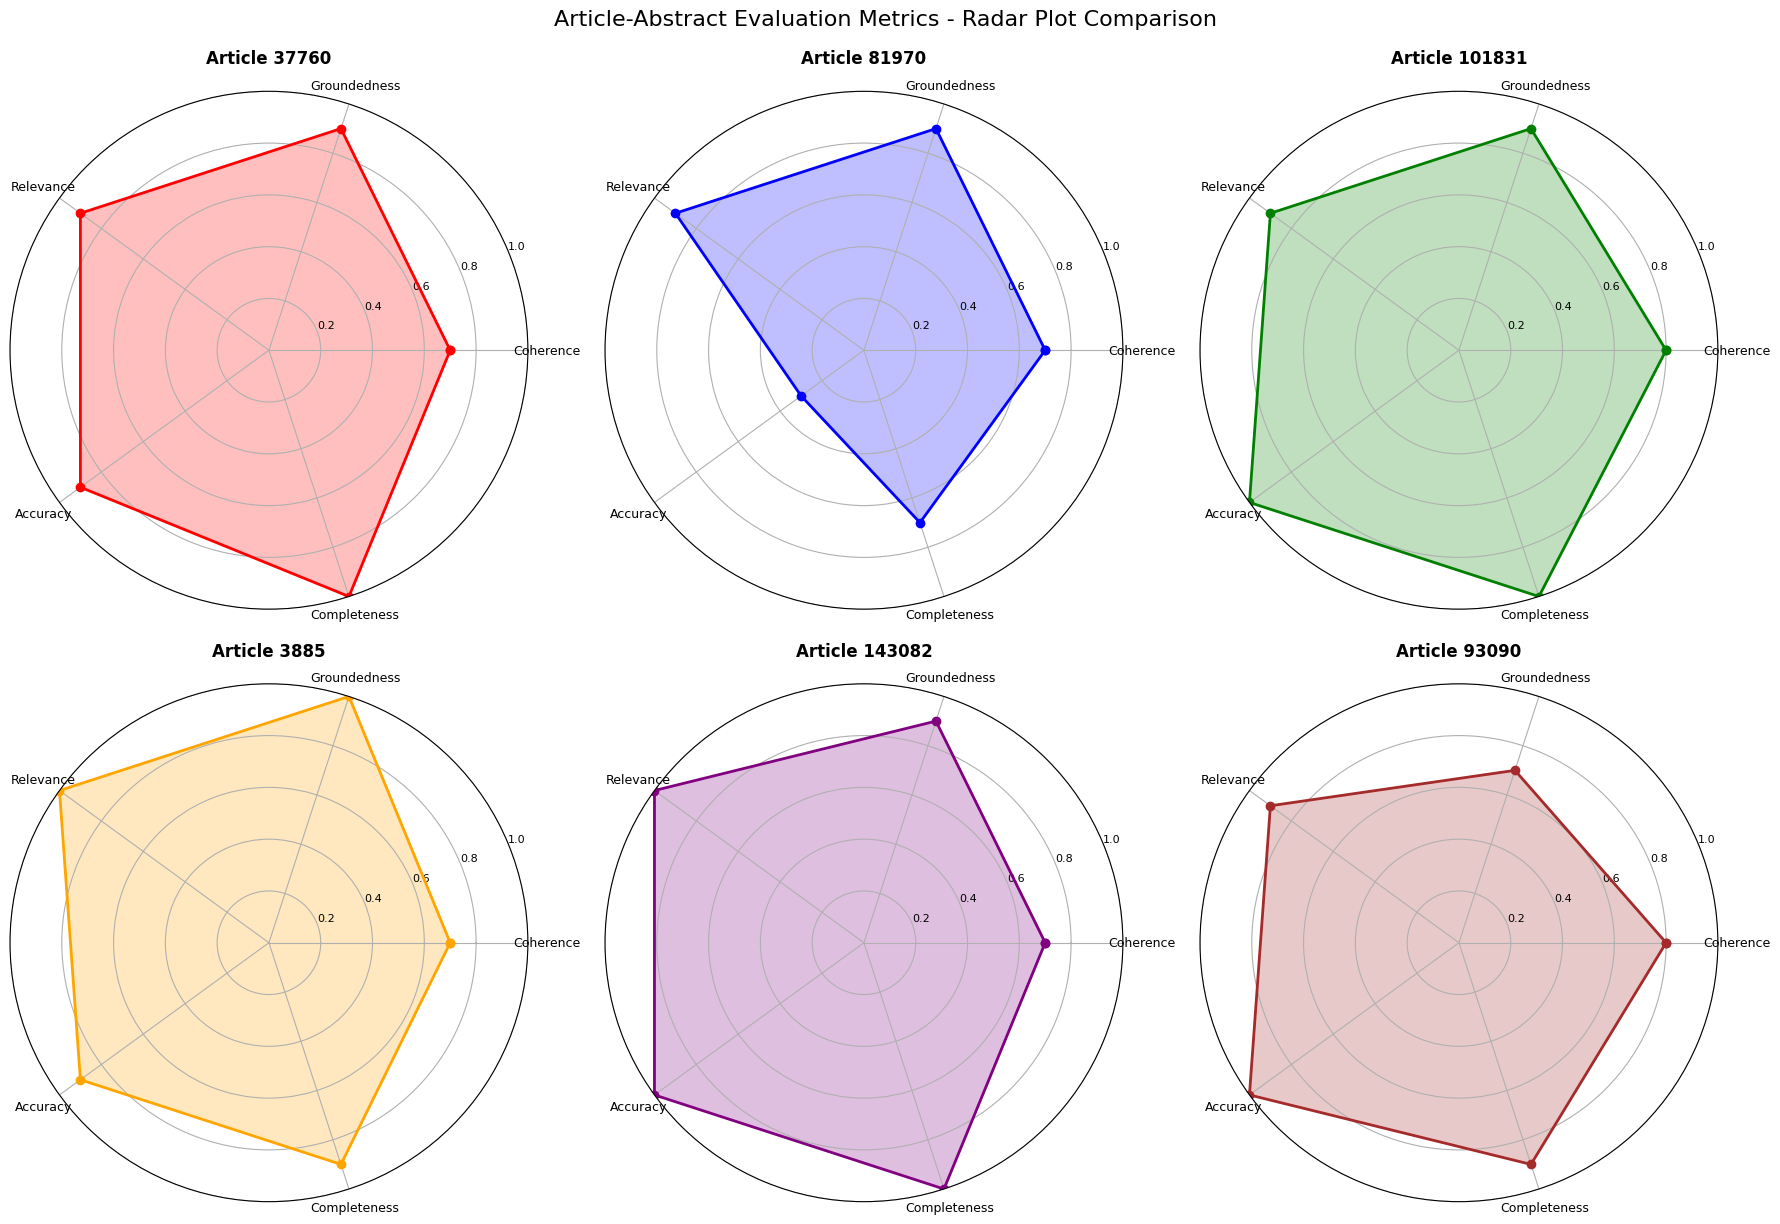


Summary of Scores:
                Coherence  Groundedness  Relevance  Accuracy  Completeness
Article 37760         0.7           0.9        0.9       0.9           1.0
Article 81970         0.7           0.9        0.9       0.3           0.7
Article 101831        0.8           0.9        0.9       1.0           1.0
Article 3885          0.7           1.0        1.0       0.9           0.9
Article 143082        0.7           0.9        1.0       1.0           1.0
Article 93090         0.8           0.7        0.9       1.0           0.9
Article 52070         0.8           1.0        0.9       1.0           0.9
Article 5179          0.9           0.9        1.0       1.0           1.0
Article 17600         0.9           1.0        1.0       1.0           1.0
Article 38817         0.8           1.0        0.9       0.9           0.9

Overall Evaluation Scores:
Article 37760: 0.880
Article 81970: 0.700
Article 101831: 0.920
Article 3885: 0.900
Article 143082: 0.920
Article 93090: 0.860


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Extract scores from the dataframe with metrics
scores_data = []
candidate_names = []

# Define the current metrics being used
current_metrics = [
    'coherence',
    'groundedness', 
    'relevance',
    'accuracy',
    'completeness'
]

for index, row in df_with_metrics.iterrows():
    # Extract scores from the actual metric columns
    scores = {}
    for metric in current_metrics:
        score_col = f"{metric}_score"
        if score_col in df_with_metrics.columns:
            scores[metric.capitalize()] = row[score_col] if pd.notna(row[score_col]) else 0
        else:
            scores[metric.capitalize()] = 0
    
    scores_data.append(scores)
    # Use index as candidate identifier
    candidate_names.append(f"Article {index+1}")

# Create radar plots
categories = list(scores_data[0].keys())
N = len(categories)

# Compute angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Colors for each candidate
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i, (scores, name, color) in enumerate(zip(scores_data, candidate_names, colors)):
    if i >= len(axes):
        break
        
    ax = axes[i]
    
    # Extract values and complete the circle
    values = list(scores.values())
    values += values[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    
    # Add category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9, rotation=45)
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
    
    # Add title with truncated name if too long
    display_name = name if len(name) <= 20 else name[:17] + "..."
    ax.set_title(f'{display_name}', size=12, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True)

# Hide any unused subplots
for i in range(len(scores_data), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Article-Abstract Evaluation Metrics - Radar Plot Comparison', fontsize=16, y=1.02)
plt.show()

# Also create a summary table
import pandas as pd

summary_df = pd.DataFrame(scores_data, index=candidate_names)
print("\nSummary of Scores:")
print(summary_df.round(3))

# Print overall evaluation scores
print("\nOverall Evaluation Scores:")
for index, row in df_with_metrics.iterrows():
    if 'overall_correctness_score' in df_with_metrics.columns:
        eval_score = row['overall_correctness_score']
        if pd.notna(eval_score):
            print(f"Article {index+1}: {eval_score:.3f}")